# Introduction: The Magnificent Seven and the Golden Cross Strategy

In this example, we demonstrate how to use the **kissbt** library to implement a simple
trading strategy based on a **Golden Cross** approach with two
**Simple Moving Averages (SMA)**.

We focus on the so-called **Magnificent Seven** – seven of the largest and most influential technology stocks:
**Apple (AAPL), Alphabet (GOOGL), Microsoft (MSFT), Amazon (AMZN), Nvidia (NVDA), Tesla (TSLA), and Meta (META).**
Additionally, we include the **S&P 500 ETF (SPY)** as a benchmark in our universe.

### How the strategy works:
- We calculate two moving averages:  
  - **SMA 128**: The 128-day moving average of closing prices
  - **SMA 256**: The 256-day moving average of closing prices
- A **buy signal** is generated when the SMA 128 crosses above the SMA 256.
- A **sell signal** is triggered when the SMA 128 crosses below the SMA 256.

### Important Notes:
This strategy is **for demonstration purposes only** and should not be considered an optimized trading strategy.
Its main purpose is to showcase how **kissbt** allows strategies to be applied effortlessly to entire universes of stocks.
While we use only **7 stocks** here for simplicity, the same approach can scale to **thousands of stocks** with ease.

In this notebook, we will:
1. Load and visualize historical stock price data.
2. Implement the Golden Cross strategy using **kissbt**.
3. Backtest the strategy and analyze its performance.

Let’s get started! 🚀

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from kissbt.strategy import Strategy
from kissbt.broker import Broker
from kissbt.entities import Order
from kissbt.engine import Engine
from kissbt.analyzer import Analyzer

plt.rcParams["axes.grid"] = True
plt.style.use("dark_background")
plt.rcParams["grid.color"] = "#222222"
plt.rcParams["figure.figsize"] = (20, 10)

# Retrieving Market Data with yFinance

To backtest a trading strategy, we first need historical stock price data. In this example, we use [**yFinance**](https://github.com/ranaroussi/yfinance), a popular Python library that provides an easy way to fetch financial data from Yahoo Finance. It is a great starting point for research and testing, as it is **simple to use, and covers a wide range of assets**.

However, for serious backtesting with longer time horizons, there are important considerations such as:
- **Survivorship bias** – Stocks that were delisted or went bankrupt do not appear in historical datasets from free sources like Yahoo Finance, potentially skewing results.
- **Corporate actions** – Adjustments for splits, dividends, and mergers may be incomplete or inconsistent.
- **Point-in-time data** – Many free datasets do not provide historical index constituents or sector classifications as they were known at a given point in time.

For more robust backtesting, professional data providers offer high-quality datasets that account for these factors, e.g. [Sharadar](https://data.nasdaq.com/publishers/SHARADAR) or [Norgate Data](https://www.norgatedata.com/).

In this example, we use **yFinance** to fetch daily stock price data for the **Magnificent Seven** and our benchmark ETF (SPY).
Since we want to **backtest our strategy for three years (2022, 2023, and 2024)**, we load **additional historical data** to calculate our indicators properly. This ensures that our moving averages are fully computed by **January 1, 2022**, when our backtest begins.

Now, let's load the data! 📊

In [2]:
tickers = ["AAPL", "GOOGL", "MSFT", "AMZN", "NVDA", "TSLA", "META", "SPY"]
df = yf.download(tickers, start="2020-01-01", end="2024-12-31", interval="1d", auto_adjust=True)

[*********************100%***********************]  8 of 8 completed


# Data Structure for kissbt

To run a backtest with **kissbt**, we need to provide historical market data in a specific **DataFrame format**. The key requirement is the **multi-index structure**, which consists of:
1. **Datetime index** (first level) – Represents the trading datetime (which is in our case simply a date) of each data point.
2. **Ticker (or asset identifier) index** (second level) – Specifies the asset being traded (e.g., stock ticker symbols).

Each row in the DataFrame corresponds to a specific **datetime and asset combination**, with columns containing price and indicator values such as:
- `open`, `high`, `low`, `close`, `volume` (from yFinance)
- Additional computed indicators, such as moving averages (`sma_128`, `sma_256`)

This format allows **kissbt** to efficiently process large universes of assets, applying the same strategy logic across thousands of stocks.

Next, we will structure our dataset accordingly and compute the necessary indicators.


In [3]:
# Stack and reset index
df = df.stack(level=1, future_stack=True).reset_index()

# Clean up column names
df.columns = df.columns.str.lower()
df.columns.name = None
df = df.rename(columns={"date": "timestamp"})

# Sort and set multi-index
df = df.sort_values(by=["timestamp", "ticker"]).set_index(["timestamp", "ticker"])

# Compute rolling means
df["sma_128"] = df.groupby("ticker")["close"].transform(lambda x: x.rolling(window=128).mean())
df["sma_256"] = df.groupby("ticker")["close"].transform(lambda x: x.rolling(window=256).mean())

# Subset date range
df = df.loc["2022-01-01":"2024-12-31"]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6016 entries, (Timestamp('2022-01-03 00:00:00'), 'AAPL') to (Timestamp('2024-12-30 00:00:00'), 'TSLA')
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   close    6016 non-null   float64
 1   high     6016 non-null   float64
 2   low      6016 non-null   float64
 3   open     6016 non-null   float64
 4   volume   6016 non-null   int64  
 5   sma_128  6016 non-null   float64
 6   sma_256  6016 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 389.2+ KB


In [5]:
df.head(16)

close        high         low        open     volume  \
timestamp  ticker                                                              
2022-01-03 AAPL    178.645645  179.499574  174.425140  174.542917  104487900   
           AMZN    170.404495  170.703506  166.160507  167.550003   63520000   
           GOOGL   144.127136  144.981509  142.856255  144.190250   28646000   
           META    336.692871  339.218991  335.350231  336.454160   14537900   
           MSFT    325.038086  328.193796  320.212277  325.620684   28865100   
           NVDA     30.066135   30.655061   29.730747   29.760693  391547000   
           SPY     454.466827  454.600030  450.794651  453.125428   72668200   
           TSLA    399.926666  400.356659  378.679993  382.583344  103931400   
2022-01-04 AAPL    176.378342  179.558457  175.809061  179.254190   99310400   
           AMZN    167.522003  171.399994  166.349503  170.438004   70726000   
           GOOGL   143.538651  145.611713  142.859724  144.529200   28400000   
           META    334.693878  341.218084  330.059300  338.095232   15998000   
           MSFT    319.464600  325.475014  316.658432  325.115724   32674300   
           NVDA     29.236647   30.412500   28.297361   30.221848  527154000   
           SPY     454.314636  456.626426  452.440486  455.903395   71178700   
           TSLA    383.196655  402.666656  374.350006  396.516663  100248300   

                      sma_128     sma_256  
timestamp  ticker                          
2022-01-03 AAPL    149.967088  138.083564  
           AMZN    171.810192  167.173311  
           GOOGL   139.389085  123.136492  
           META    344.069136  318.930950  
           MSFT    298.605657  266.580403  
           NVDA     24.169422   19.445850  
           SPY     426.626472  402.110737  
           TSLA    286.736615  260.188581  
2022-01-04 AAPL    150.274985  138.258612  
           AMZN    171.747481  167.178865  
           GOOGL   139.537740  123.355924  
           META    343.927957  319.163075  
           MSFT    299.003129  266.985196  
           NVDA     24.238118   19.509633  
           SPY     426.973777  402.523146  
           TSLA    287.962370  260.818269

# Stock Price and Moving Averages

The figure below presents the price movements of the **"The Magnificent Seven"**.

For each stock, we plot the **closing price** along with our two **moving average indicators**:
1. **128-day Simple Moving Average (SMA 128)** – Orange dashed line
2. **256-day Simple Moving Average (SMA 256)** – Green dashed line

These moving averages help identify trends and potential **buy or sell signals** based on their crossover behavior.
- When **SMA 128 crosses above SMA 256**, it suggests a potential **bullish (buy) signal**.
- When **SMA 128 crosses below SMA 256**, it indicates a possible **bearish (sell) signal**.

This visualization gives an overview of market trends and how our strategy reacts to changing price movements.


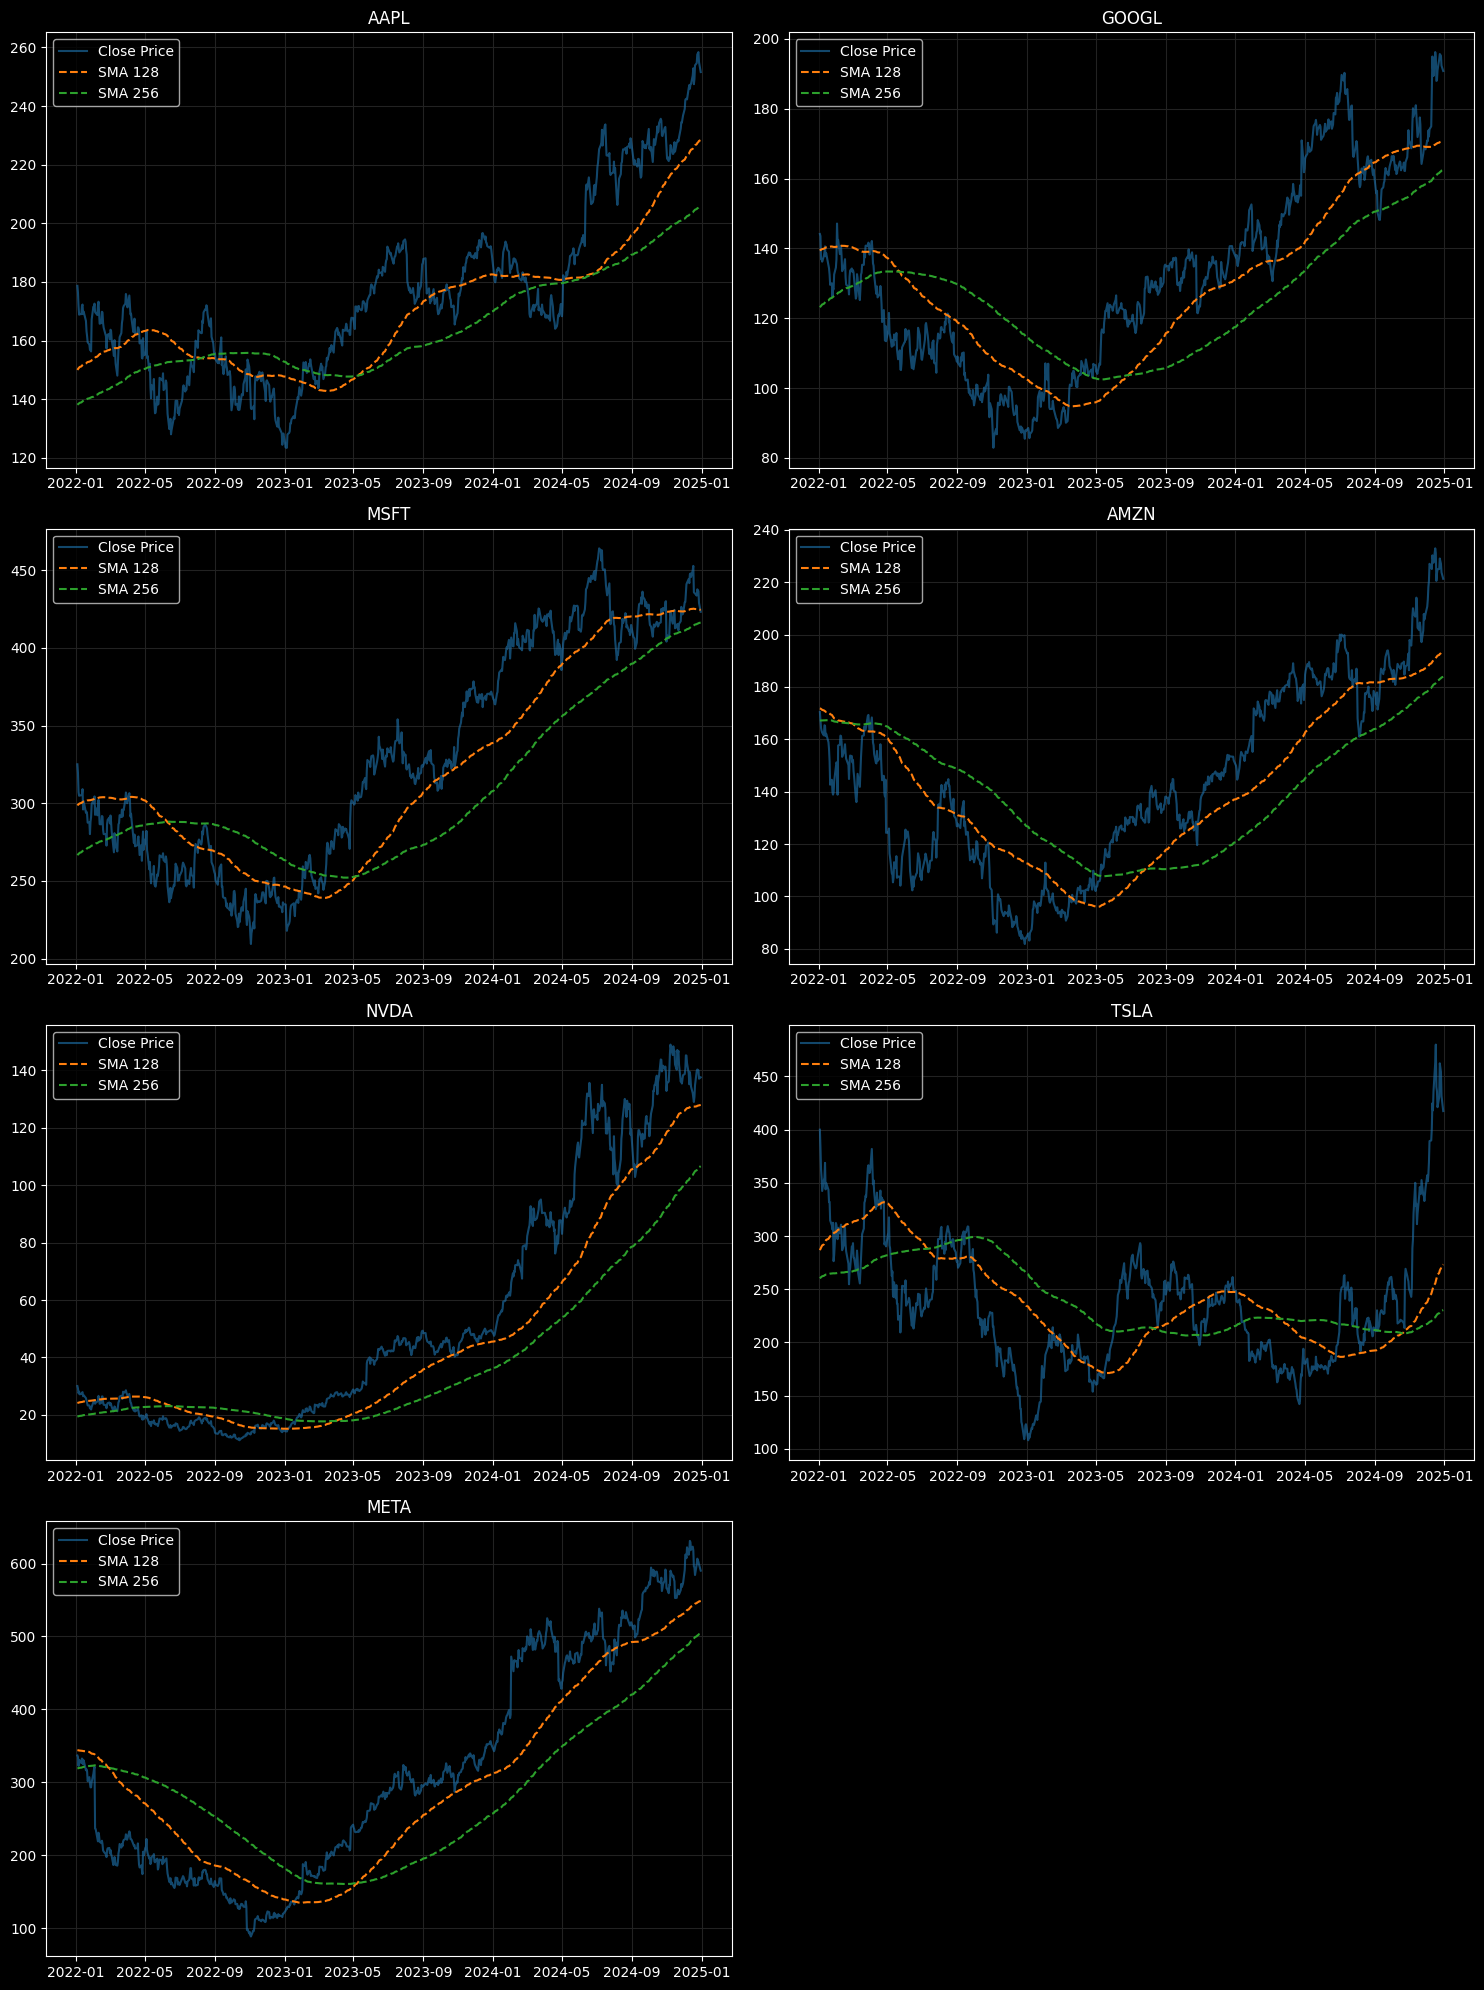

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    ax = axes[i]
    df_ticker = df.xs(ticker, level='ticker')
    
    ax.plot(df_ticker.index, df_ticker['close'], label='Close Price', color='#1f77b4', alpha=0.6)
    ax.plot(df_ticker.index, df_ticker['sma_128'], label='SMA 128', color='#ff7f0e', linestyle='--')
    ax.plot(df_ticker.index, df_ticker['sma_256'], label='SMA 256', color='#2ca02c', linestyle='--')
    
    ax.set_title(ticker, color='white')
    ax.legend()

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Implementing a Trading Strategy in `kissbt`

In `kissbt`, trading strategies are implemented by subclassing the `Strategy` class.
A strategy defines **when to buy and sell assets** based on market conditions and
indicator signals.

### The `GoldenCrossStrategy`

In this example, we implement a simple **Golden Cross Strategy**.  
This strategy is based on two **Simple Moving Averages (SMA)**:  
- **SMA 128 (shorter-term trend)**  
- **SMA 256 (longer-term trend)**  

### Trading Logic:
- **Buy Signal:** If the **SMA 128** is above the **SMA 256**, the strategy **buys**
the stock.  
- **Sell Signal:** If the **SMA 128** falls below the **SMA 256**, the strategy
**sells** all positions in that stock.
- **Position Sizing:** In our example strategy, we simply buy shares for 1/7 of the
portfolio value when we receive a buy signal. The strategy could probably be improved by
also introducing a rebalancing mechanism.

### How the `Strategy` Class Works:
- The method `generate_orders` is called on each trading day or datetime depending on
your dataset.
- It receives `current_data`, a **dataframe containing prices and indicators** for all
stocks.
- How the orders are generated by the strategy is completely up to the creator, normally
the following steps are carried out:
    - It loops through all **open positions** and sells stocks when the
    **sell condition is met**.
    - It loops through all **available stocks** and buys stocks when the
    **buy condition is met**.


In [7]:
class GoldenCrossStrategy(Strategy):
    def __init__(self, broker):
        super().__init__(broker)

    def generate_orders(
        self,
        current_data: pd.DataFrame,
        current_date: pd.Timestamp,
    ) -> None:
        for ticker in self._broker.open_positions:
            if (
                current_data.loc[ticker, "sma_128"]
                < current_data.loc[ticker, "sma_256"]
            ):
                self._broker.place_order(
                    Order(ticker, -self._broker.open_positions[ticker].size)
                )

        for ticker in current_data.index:
            if ticker == self._broker.benchmark or ticker in self._broker.open_positions:
                continue
            if (
                current_data.loc[ticker, "sma_128"]
                >= current_data.loc[ticker, "sma_256"]
            ):
                size = round(
                    self._broker.portfolio_value
                    / 7
                    / current_data.loc[ticker, "close"]
                )
                self._broker.place_order(Order(ticker, size))

# Structure of `kissbt` and Running a Backtest

`kissbt` is designed to be a **simple yet powerful** backtesting engine.
It consists of three key components:

1. **`Broker`** – Handles capital, executes trades, and tracks open and closed
positions.
2. **`Strategy`** – Defines trading rules and generates buy/sell signals.
3. **`Engine`** – Runs the backtest by applying the strategy on historical data.

In [8]:
broker = Broker(
    start_capital=100000, # Initial capital of $100,000
    fees=0.001,           # 0.1% fee per trade
    benchmark="SPY",      # Benchmark ticker
)

strategy = GoldenCrossStrategy(broker) # Instantiate strategy

engine = Engine(broker=broker, strategy=strategy) # Create the backtesting engine
engine.run(df) # Run the backtest on the historical data

In [9]:
len(broker.closed_positions)

15

In [10]:
broker.closed_positions

[ClosedPosition(ticker='META', size=42, purchase_price=np.float64(338.09523187687694), purchase_timestamp=Timestamp('2022-01-04 00:00:00'), selling_price=np.float64(208.72492530275795), selling_timestamp=Timestamp('2022-03-01 00:00:00')),
 ClosedPosition(ticker='AMZN', size=84, purchase_price=np.float64(170.43800354003906), purchase_timestamp=Timestamp('2022-01-04 00:00:00'), selling_price=np.float64(153.531494140625), selling_timestamp=Timestamp('2022-03-03 00:00:00')),
 ClosedPosition(ticker='GOOGL', size=99, purchase_price=np.float64(144.52920029280338), purchase_timestamp=Timestamp('2022-01-04 00:00:00'), selling_price=np.float64(104.35961425816333), selling_timestamp=Timestamp('2022-05-25 00:00:00')),
 ClosedPosition(ticker='MSFT', size=44, purchase_price=np.float64(325.1157242107018), purchase_timestamp=Timestamp('2022-01-04 00:00:00'), selling_price=np.float64(239.04634693147696), selling_timestamp=Timestamp('2022-06-13 00:00:00')),
 ClosedPosition(ticker='NVDA', size=475, purch

# Analyzing the Backtest Results  

Once the backtest is completed, we use the `Analyzer` class to evaluate the strategy's performance. The analyzer provides **key performance metrics** and generates plots for **equity growth** and **drawdowns**.

In [11]:
analyzer = Analyzer(broker)
performance_metrics = analyzer.get_performance_metrics()
performance_metrics

{'total_return': 0.6749559848791515,
 'annual_return': 0.188680036152014,
 'sharpe_ratio': 0.851032890381295,
 'max_drawdown': 0.3244387046832524,
 'volatility': 0.23622968364014876,
 'win_rate': 0.4666666666666667,
 'profit_factor': 3.1724191658795435,
 'total_benchmark_return': 0.2866223398665415,
 'annual_benchmark_return': 0.08812241860290748}

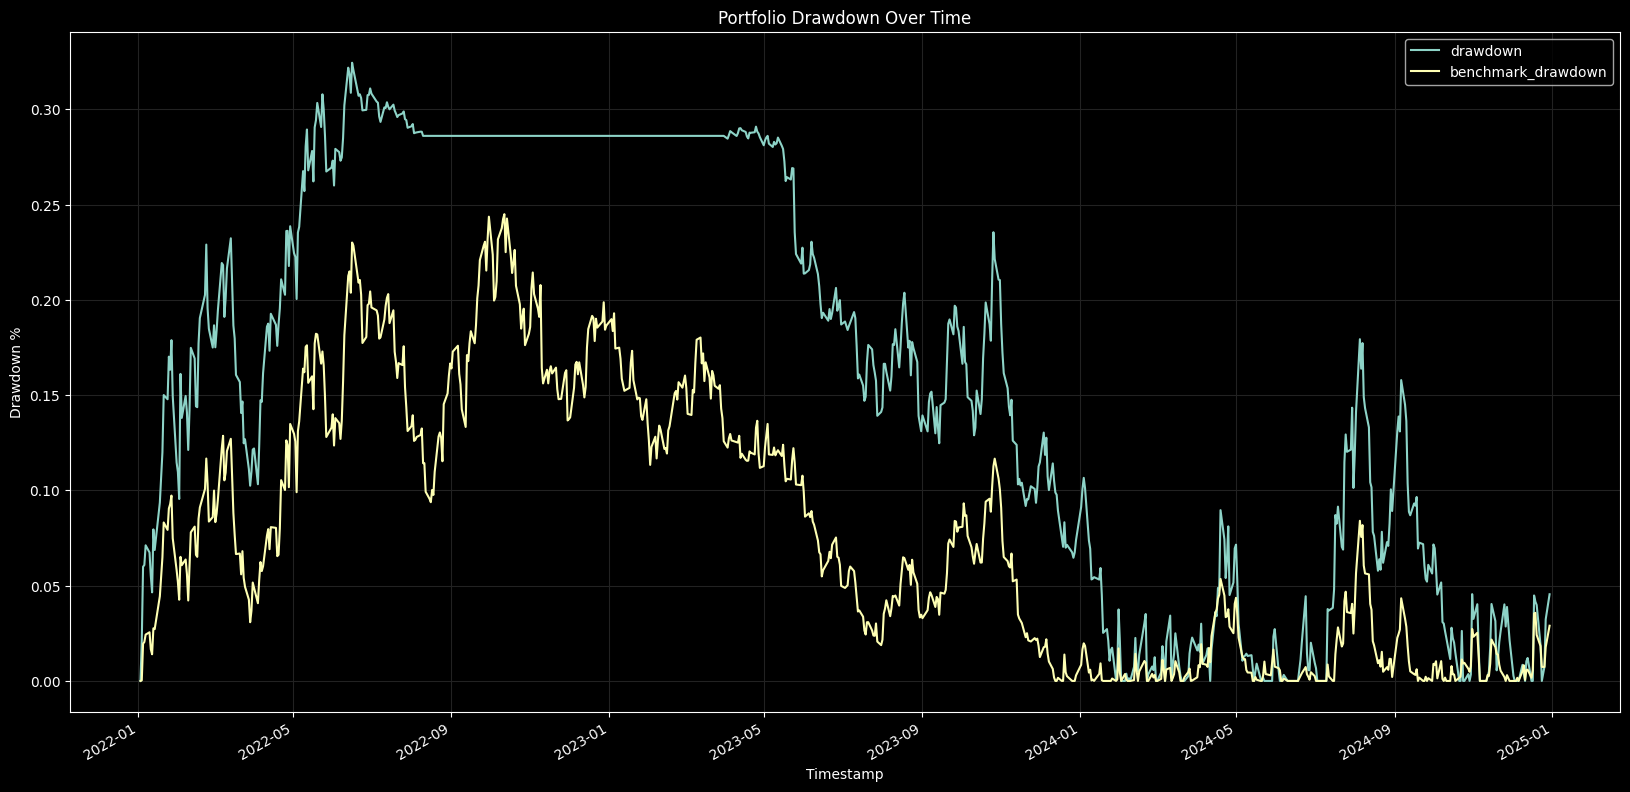

In [12]:
analyzer.plot_drawdowns()

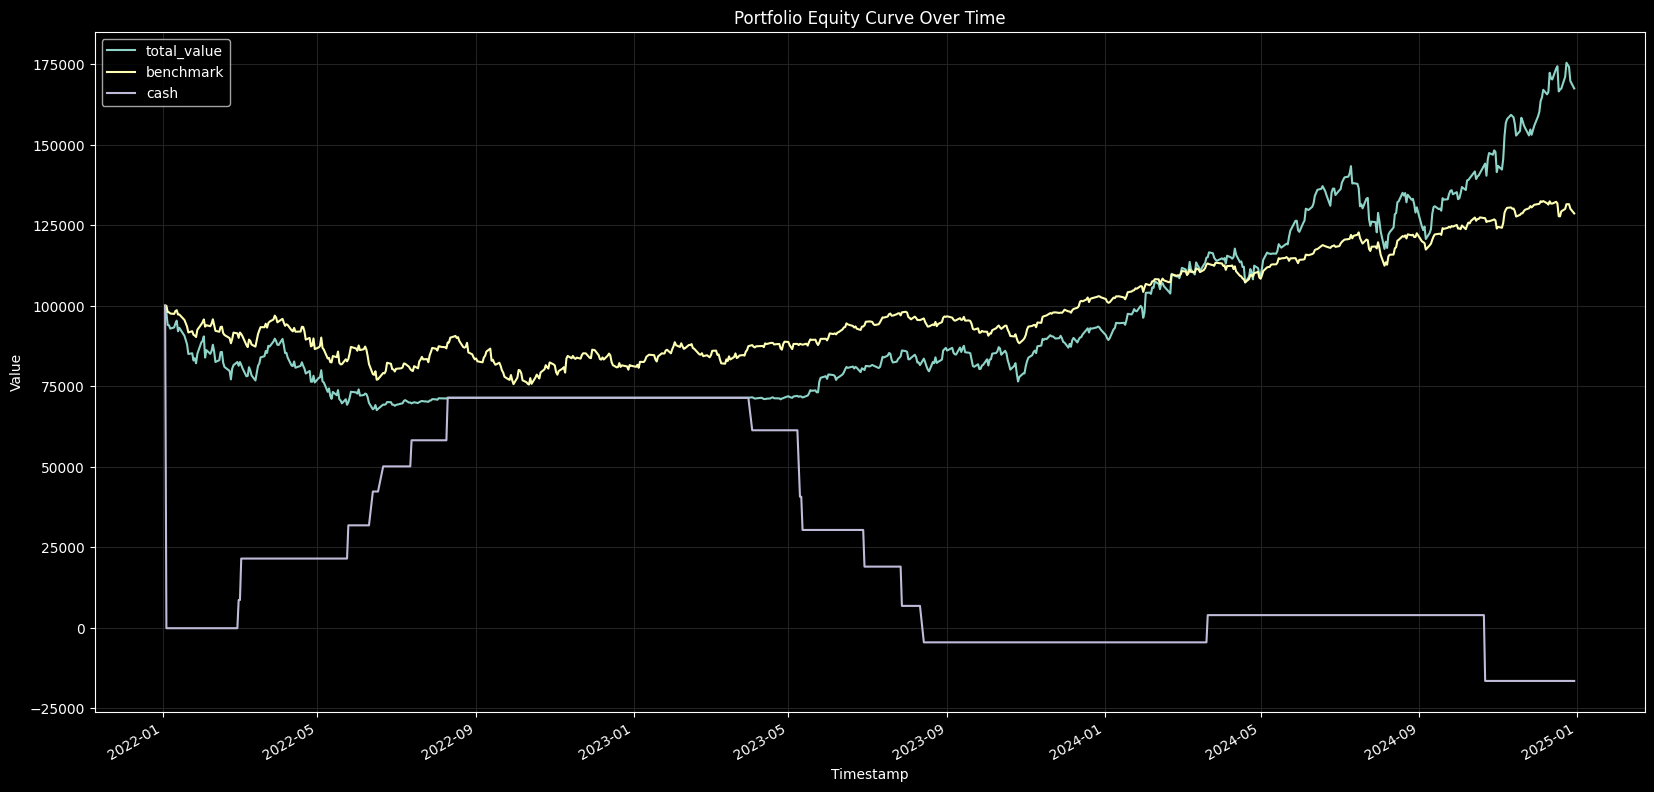

In [13]:
analyzer.plot_equity_curve()

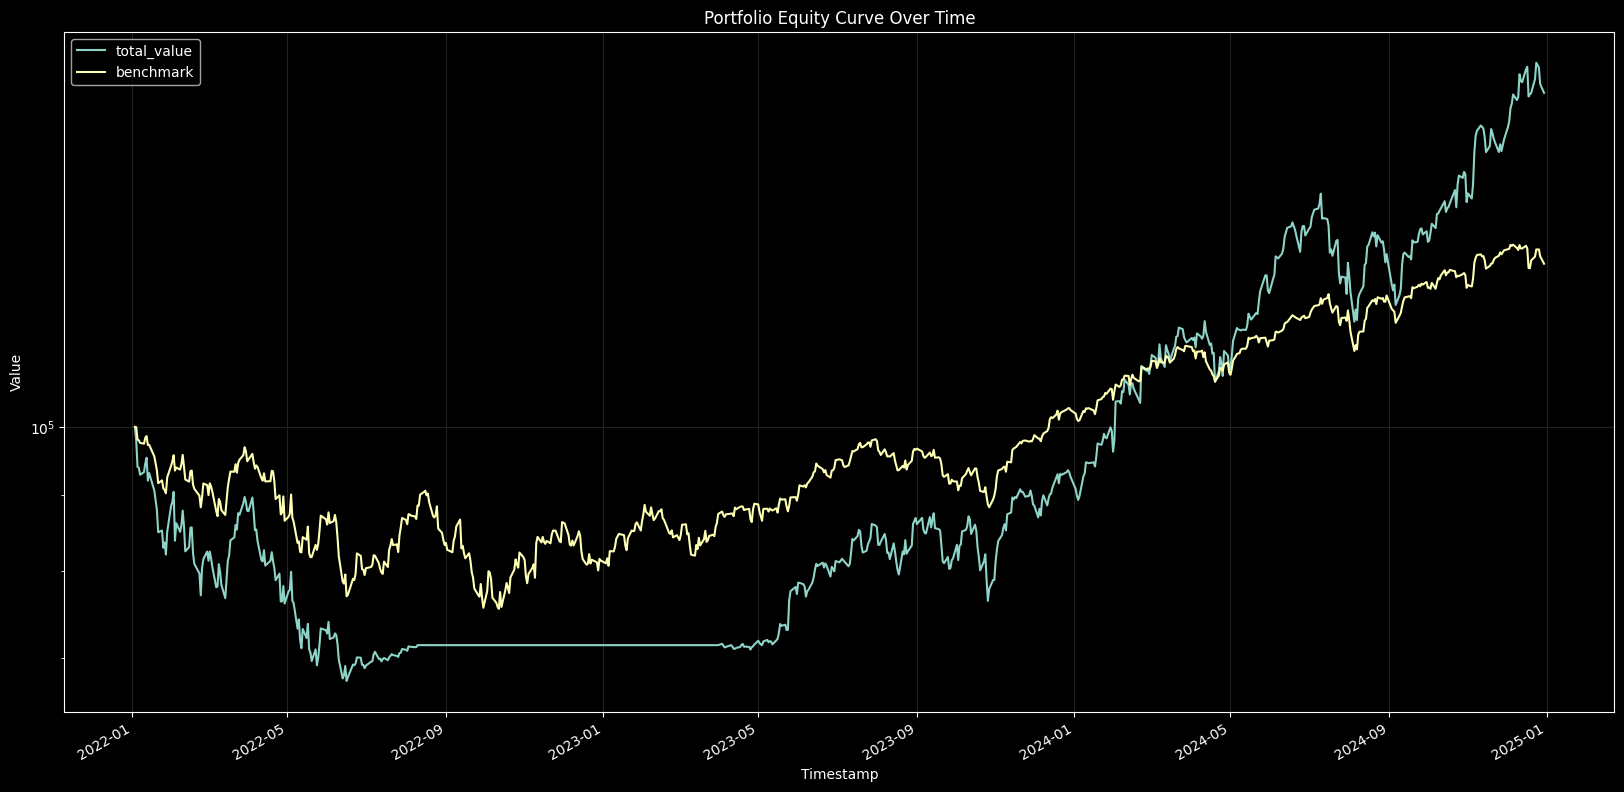

In [14]:
analyzer.plot_equity_curve(logy=True)